In [1]:
%matplotlib inline

# Red neuronal de $\sin{x}$

En este cuaderno pretendemos entrenar una red neuronal para que saque el seno de la entrada. Para ello hemos escogio una aruiqtectura muy pequeña, de una sóla capa oculta de tres neuronas, tal y como podemos ver en la siguiente figura:

<img src="img/nn_1-3-1.png" />

Veamos como debemos proceder para poder realizarla con Pytorch.

## Librerías

Vamos a usar diferentes librerías. Veamos a que dedicamos cada una de ellas:

- `torch` y demás variantes: Es la librería que contiene todas las funciones necesarias para virtualizar y entrenar la red. Su módulo `nn` tiene todo lo necesario para construir el modelo. En `nn.funcional` encontramos admás un conjunto de funciones para calcular el coste de la red.

- `matplotlib.pyplot` para la representación gráfica.

- `math` para obtener el valor de $\pi$

- `IPython.display` para obtener el progreso por pantalla del entrenamiento




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from IPython.display import display, clear_output

## Parámetros

En esta sección vamos a definir los parámetros para configurar la arquitectura de red y los parámtros que intervienen en la simulación. También definimos el valor de $\pi$ usando la cosntante que recoge la libería `math`.

### Parámetros de arquitectura

- $D_{in}$, el número de netradas de la red. Deberá  ser igual a 1.
- $H$, el número de unidades en la capa oculta. Este será 3.
- $D_{out}$, número de salidas de la red. Sólo tendremos una salida en este caso.

### Parámetros de entrenamiento

- $N$, el número de datos que generamos para el entrenamiento de la red.
- $\delta_{limit}$, `delta_limit` en el código. Cuando el coste cambie menos de este valor durante 100 itearaciones del _training set_ dejaremos de entrnar la red.
- $t_{max}$, `epochs` en el código. Es otra manera de limitar el entramneitno. Hasta que alcancemos este número de iteracciones en el código.
- $\alpha$, `learning_rate` en el código. Factor de aprendizaje de la red en cada paso de entrenamiento.

In [3]:
pi = math.pi #Definimos pi

# D_in numero de entradas;
# H numero de neuronas en la capa oculta;
#D_out numero de salidas;
D_in, H, D_out = 1, 3, 1

#N el tamaño del train set; 
#delta_limit minimo cambio en coste con el que parar la simulación;
#epochs numero maximo de itereacciones si estamos con el for;
N, delta_limit, epochs, learning_rate = 500, 1e-4, 100000, 1e-4

## Generamos el _training set_

Debemos generar el _training set_. Dado que queremos que la red nos devuelva $\sin{x}$ bastará con tener datos de $x$ entre $-\pi$ y $+\pi$. Los generamos aleatoriamente con la función `torch.rand()`, que ya nos los devuelve como un tensor de `torch`. Para obtener los datos objetivo (_target_) usamos la función de `torch`, `torch.sin()` que acepta tensores y devulve tenosores. Representamos los datos con `plt.plot()`. 

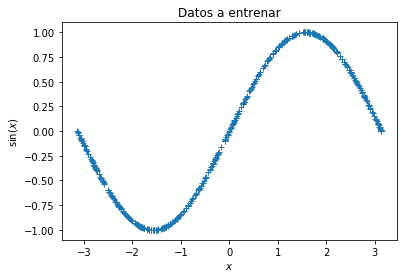

In [4]:
# Creamos N datos aleatorios entre -pi y pi y calculamos su seno
x = 2*pi*torch.rand(N, D_in) - pi
y = torch.sin(x)

#Represnetamos graficamente
plt.plot(x, y, '+', label='Training set')
plt.title('Datos a entrenar')
plt.xlabel('$x$')
plt.ylabel('$\sin(x)$')
plt.show()

## Creamos la red neuronal

En esta parte vamos a definir la aruitectura de red con los parámetros previamente definidos. Para ello camos a crear una clase de Python tamendo como base el módulo `torch.nn.Module` de PyTorch. En la primera parte, el _constructor_ (`__init__`), se define el tipo de conexión entre capas. en nuestro caso, que queremos que sea _fully conencted_ lo hacemos usando `nn.Linear()`cuyos argumentos son las dimensiones de la capa anterior y de la posterior. Por defecto se define para que esa capa tenga _bias_. En la segunda parte se define la función `foward`. en esta se define como se va a proceder a la hora de realizar la propagación de la señal. Permite conectar las capas definidas en el _cosntructor_ y definir cuales con las funciones de activación de las neuronas. PAra estas funciones de activación usamos el subpaquete `torch.nn.Functional` que hemos abierto como `F`. En nuestro caso hemo elegido usar la función sigmoide, $f(x) = \frac{1}{1+e^{-x}}$. Finalmente, para inicializar el modelo basta con asignarlo a un objeto, en esta caso `model`.

In [5]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        En el 'constructor' inicializamos las capas dandoles 
        las dimensiones de ntrada y salida de cada una de ellas 
        y las asignamos como variables de la clase
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        En la función de propagación, 'forward', recogemos el tensor de entrada
        y configuramos como es su propagación hasta la salida. Podemos usar las 
        capas definidas en el 'constructor' o realiazr cualqueir operación sobre él. 
        En este caso colocamos la función de activación de las euronas de la capa 
        oculta. A la salida no hay función de activación porque queremos obtener el seno.
        """
        x = self.linear1(x)
        x = self.linear2(F.sigmoid(x))
        return x

# Inicializamos el modelo
model = TwoLayerNet(D_in, H, D_out)

## Funciones de coste y optimizador

En esta parte vamos a aprovechar el músculo que nos ofrece la librería `torch`. Recoge un montón de posibilidades tanto a la hora de calcular el coste, $J$, de la red como para optimizar el entrenamiento de esta. Para el coste vamos a elegir una de las más habituales, la de la suma de las diferencias al cuadrado, `torch.nn.MSELoss(reduction='sum')` aunque PyTorch cuneta con muchas [más](https://pytorch.org/docs/stable/nn.html#loss-functions).

Por otro lado tenemos el optmizador, el cual nos engloba la parte del aprendizaje de la red. Podemos elegir diferentes algoritmos de entre [los que ofrece PyTorch](https://pytorch.org/docs/stable/optim.html#algorithms), en  nuestro caso hemos elegido el grandiente descendiente estocástico (`torch.optim.SGD()`). 

In [6]:
# Declaramos la función de coste y el optimizador. A este
#último le debemos pasar los parámetros del modelo para 
#que los actualice en cada paso de parendizaje.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Aprendizaje

En esta fase vamos a ver como se da el aprendizaje de la red. Una de las primeras cosas que debemos elegir es como cortar este aprendijaze. Dado que vamos a entrenar la red sobre el mismo _training set_ varias veces (del orden de unas $10^5$ por lo menos), es bueno que sepamos cuando es hora de parar. La forma más bruta pero también la más basica es utilizar un bucle hasta que se llegue al número máximo de iteraciones que se pedia en los parámetros del principio. Esto se podría hacer con una línea de bucle como `for t in range(epochs):`. Pero nosotros queremos ser más sutiles. En nuestro caso hemos optado por definir un indicador de cómo de bien la red está aprendiendo. Para ello cada 100 iteracciones de aprendizaje sobre el _training set_ vamos a calular $\delta = J_t - J_{t-100}$. Donde $J_t$ es el coste de la red en la iteracción $t$. Como hemos definido en los parámetros de más arriba uno que era $\delta_{limit}$ cuando $\delta$ baje de este valor, pararemos el apredizaje.

Así pues, en las primeras líneas de código inicializamos varias variables que nos permiten entrar en esta dinámica para calcular las $\delta$. A partir de la línea del `while` entramos en la dinámica del aprendizaje. Lo primero que se hace es calcualr las predicciones del modelo para las entradas, `y_pred = model(x)`. Como se puede ver se calculan todas de golpe, en vez de una a una, como podría pensarse a priori. Una vez obtenidas las predicciones, obtenemos el coste `loss`con el critetio seleccionado en la sección de más arriba. A continuación encontraos un condicional para que nos permite sacar información de vez en cuando y nos limita la evaluación de $\delta$ cada 100 iteracciones. Después ponemos a cero el contador de gradientes con la instancia `optimizer.zero_grad()`, algo necesario porque no se puede hacer dos retropropagaciones seguidas. Luego retropropagamos con la instancia `loss.backward()` y finalmente le decimos al optmizador que proceda a dar un paso de arendizaje con `optimizer.step()`.

Una vez realizado el aprendizaje guardamos el modelo con la instancia `torch.save(model.state_dict(), 'PATH')`.

In [7]:
t=0 #Inicializamos el contador de iteracciones
loss_viejo = 1000 #Inicalizamos el coste  viejo para que la primera delta se pueda calcular
delta = 100 #Inicializamos delta para que podamos entrar en el bucle
#for t in range(epochs):
while delta>delta_limit: #Hasta que no lleguemos a la delta_limit iteramos:
    
    y_pred = model(x) #Obtenemos las precciones del modelo

    
    loss = criterion(y_pred, y) #Calculamos el coste
    
    if t % 100 == 0: #Cada 100 iteracciones hacemos:
        delta = loss_viejo - loss.item() #El caclulo de delta
        loss_viejo = loss.item() #Guardamos el coste actual ara el futuro calculo de delta
        clear_output(wait=True) #esto nos permite actulizar los datos de pantalla unos sobre otros
        display('Epoch: '+str(t)+', Delta: ' + '{:06.4f}'.format(delta) + ', Loss: '+'{:05.3f}'.format(loss.item())) 
        #Sacamos la info cruda por pantalla
        
    optimizer.zero_grad() #Ajustamos a cero los gradientes
    loss.backward() #Retro propagamos
    optimizer.step() #Hacemos un paso de aprendijaze

    t=t+1 #Actualizamos el contador de iteracciones


torch.save(model.state_dict(), './seno_nn_model.pth') #Guardamos el modelo

'Epoch: 47200, Delta: 0.0001, Loss: 0.007'

## _Test set_

En esta sección de código encontramos lo necesario para representar el training set y el test set del caul generamos las salidas ahi mismo con la instancia `y_test = model(x_test)`.

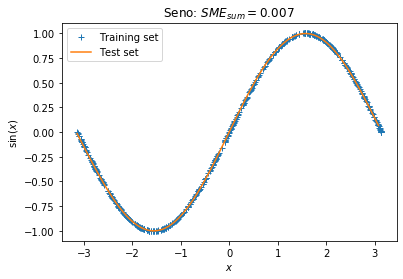

In [8]:
with torch.no_grad(): #Sin tener en cuenta los gradientes de las siguientes operaciones:
    N_inter = 100 #Número de puntos en el test set
    x_test = torch.arange(-pi, pi, 2*pi/N_inter).view(N_inter, 1) #Generamos el test set
    y_test = model(x_test)
    
    #Ploteamos el training set y el test set
    plt.figure()
    plt.plot(x, y, '+', label='Training set')
    plt.plot(x_test, y_test, '-', label='Test set')
    plt.title('Seno: $SME_{sum}='+'{:05.3f}'.format(loss.item())+'$')
    plt.xlabel('$x$')
    plt.ylabel('$\sin(x)$')
    plt.legend(loc='best')
    plt.savefig('seno_nn.png', dpi=600)
    plt.show()

## ¿Cuáles son los parámtros de mi red?

Aquí vemos cual es la sintaxis para obtener los pesos de la red:

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear1.weight tensor([[-1.1775],
        [ 1.3397],
        [-1.1243]])
linear1.bias tensor([-3.3717, -3.8611, -0.0891])
linear2.weight tensor([[ 3.8317, -3.3234, -4.4447]])
linear2.bias tensor([2.0673])


## ¿Qué hay mas allá del _training set_?

Vamos a explorar que pasa si nos salimos de la zona en la que hemos entrenado el modelo, es decir fuera del rango $(-\pi, \pi)$.

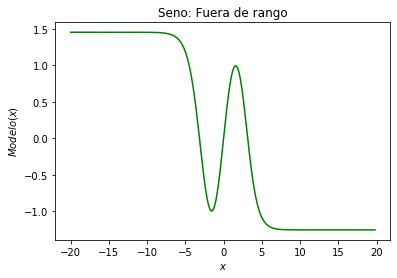

In [10]:
with torch.no_grad():
    N_inter = 200 #Número de puntos en el set
    x_ext = torch.arange(-20, 20, 40/N_inter).view(N_inter, 1) #Generamos el set
    y_ext = model(x_ext)

    #Ploteamos el set de fuera de rango
    plt.figure()
    plt.plot(x_ext, y_ext, 'g-')
    plt.title('Seno: Fuera de rango')
    plt.xlabel('$x$')
    plt.ylabel('$Modelo(x)$')
    plt.savefig('seno_nn_outofrange.png', dpi=600)
    plt.show()

## ¿Cómo puedo entrenar mi red en una GPU?

En esta parte vamos a exlplorar el uso de otras unidades de procesamiento, las GPUs frente a lo que hemos usado hasta ahora en el programa, las CPUs. Para ello primero debemos conocer si nuestro equipo cuenta con una GPU y tenemos todo preparado para usarla con PyTorch. El siguiente código nos dirá si es así. Si cuentas con una GPU pero te dice que no es compatible con CUDA puedes encontrar una posible solución siguiente [esta instalación.]()

In [11]:
if torch.cuda.is_available(): 
    print('El dispositivo que se usará a partir de ahora es ' + torch.cuda.get_device_name(0))
    device = torch.device("cuda:0")
else:
    print('Tu equipo no cuenta con un dispositivo compatible con CUDA')
    device = torch.device("cpu")

El dispositivo que se usará a partir de ahora es GeForce 840M


### Lanzamos el modelo sobre la GPU

Debes tener en cuenta que uso de la GPU se nota cuando los modelos de red son mucho mas complejos que el que hemos usado, pero aun así este ejemplo puede servir de como se podría usar para entrenar una red. Simplemnete usamos el atributo `.to(device)` para pasar el modelo, el _training set_ y el criterio de cómputo de coste a la GPU que previamente hemos definido como `device`. Otro detalle es que nose puede convertir directametne un tensor alojado en la GPU a un array de `numpy` para ser _ploteado_, por ello es necesario pasarlo pirmero a la CPU usando el atributo `.cpu()`. El resto de sintaxis es la misma.

'Epoch: 99900, Delta: 100.0000, Loss: 0.783'

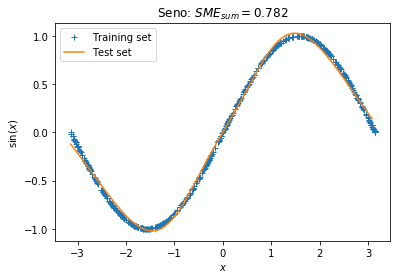

In [12]:
model = (TwoLayerNet(D_in, H, D_out)).to(device)
x = x.to(device)
y = y.to(device)

criterion = criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

t = 0 #Inicializamos el contador de iteracciones
loss_viejo = 1000 #Inicalizamos el coste  viejo para que la primera delta se pueda calcular
delta = 100 #Inicializamos delta para que podamos entrar en el bucle
for t in range(epochs):
#while delta>delta_limit: #Hasta que no lleguemos a la delta_limit iteramos:
    
    y_pred = model(x) #Obtenemos las precciones del modelo

    
    loss = criterion(y_pred, y) #Calculamos el coste
    
    if t % 100 == 0: #Cada 100 iteracciones hacemos:
        #delta = loss_viejo - loss.item() #El caclulo de delta
        #loss_viejo = loss.item() #Guardamos el coste actual ara el futuro calculo de delta
        clear_output(wait=True) #esto nos permite actulizar los datos de pantalla unos sobre otros
        display('Epoch: '+str(t)+', Delta: ' + '{:06.4f}'.format(delta) + ', Loss: '+'{:05.3f}'.format(loss.item())) 
        #Sacamos la info cruda por pantalla
        
    optimizer.zero_grad() #Ajustamos a cero los gradientes
    loss.backward() #Retro propagamos
    optimizer.step() #Hacemos un paso de aprendijaze

    t=t+1 #Actualizamos el contador de iteracciones

with torch.no_grad(): #Sin tener en cuenta los gradientes de las siguientes operaciones:
    N_inter = 100 #Número de puntos en el test set
    x_test = (torch.arange(-pi, pi, 2*pi/N_inter).view(N_inter, 1)).to(device) #Generamos el test set
    y_test = model(x_test).to(device)
    
    #Ploteamos el training set y el test set
    plt.figure()
    plt.plot(x.cpu(), y.cpu(), '+', label='Training set')
    plt.plot(x_test.cpu(), y_test.cpu(), '-', label='Test set')
    plt.title('Seno: $SME_{sum}='+'{:05.3f}'.format(loss.item())+'$')
    plt.xlabel('$x$')
    plt.ylabel('$\sin(x)$')
    plt.legend(loc='best')
    plt.savefig('seno_nn_gpu.png', dpi=600)
    plt.show()